# Project Report version 1: Predicting Airbnb Listing Prices with XGBoost
Group: Paul Bullier

    1. Objective and Overall Approach (Preamble)
My goal for this project is to predict the log of Airbnb listing prices. I first tarted working with simple regressions, then tested the RandomForestRegressor model, manually selecting the columns and parameters to use.

However, this method produced mixed results (I was able to reach a maximum R² of 0.53). I therefore decided to use XGBoost Regressor as the main algorithm, a tree-based boosting model known for its strong performance, especially in Kaggle competitions and in cases where tabular datasets are very large, as is the case here.



In [1]:
# -*- coding: utf-8 -*-
"""
Modèle de prédiction du prix Airbnb 

"""

#  Importation des bibliothèques nécessaires
import pandas as pd                     
import numpy as np                      
import matplotlib.pyplot as plt          
import seaborn as sns                    

#  Scikit-learn : outils de machine learning
from sklearn.model_selection import train_test_split            
from sklearn.pipeline import Pipeline                           
from sklearn.impute import SimpleImputer                        
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer                   
from sklearn.metrics import mean_squared_error, r2_score        

#  Le modèle de machine learning/ J'utilise "XGBoost"
from xgboost import XGBRegressor




#  1. Chargement des données
print(" Chargement des données...")
train_df = pd.read_csv(r'C:\Users\paulb\Downloads\Airbnb\airbnb_train.csv')
test_df = pd.read_csv(r'C:\Users\paulb\Downloads\Airbnb\airbnb_test.csv')
print(f" Données chargées. Taille train: {train_df.shape}, test: {test_df.shape}")

# Aperçu des données
print("Train data head:")
train_df.sample(3)





 Chargement des données...
 Données chargées. Taille train: (22234, 28), test: (51877, 27)
Train data head:


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
16271,18546212,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5,1.0,Real Bed,strict,True,...,2017-05-07,38.889400,-76.988657,Lovely Capitol Hill 1BR Apartment,Capitol Hill,94,97.0,20003,1.0,2.0
14557,3643673,4.382027,Apartment,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,flexible,True,...,NaN,40.726268,-73.980195,Master Bedroom & Private Office,Alphabet City,0,NaN,10009.0,1.0,1.0
19492,17921374,5.393628,Condominium,Private room,"{TV,""Air conditioning"",Kitchen,Elevator,Heatin...",2,1.0,Real Bed,flexible,True,...,2017-08-01,40.761349,-73.966451,Sleep Cosy in an Elegant Midtown East Apartment,Midtown East,1,100.0,10022,1.0,1.0


    2. Qualitative Exploration of the Data

Let’s start with a simple overview to examine the values taken by the log of the price.
The log of the price appears to follow a bell-shaped distribution, with a peak around 4.5, which corresponds to a price of approximately 90 dollars.
Most prices fall between 3 and 7, which corresponds to values between 20 and 1000 dollars.

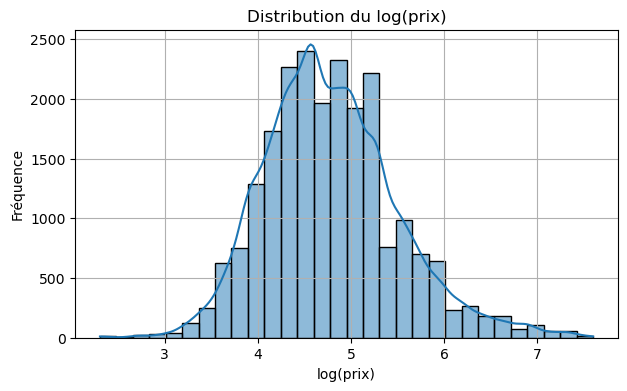

In [2]:

# Distribution du log(prix)
plt.figure(figsize=(7, 4))
sns.histplot(train_df['log_price'], bins=30, kde=True)
plt.title("Distribution du log(prix)")
plt.xlabel("log(prix)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


My initial assumption was that the price mainly depends on the type of accommodation.
And this is indeed the case: shared rooms are much cheaper
than entire homes.

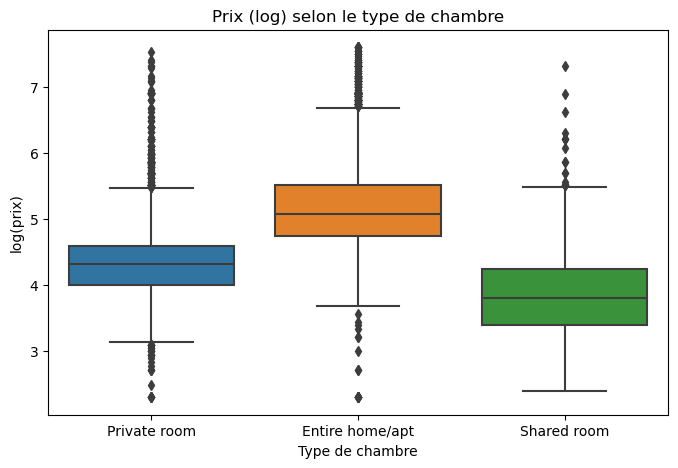

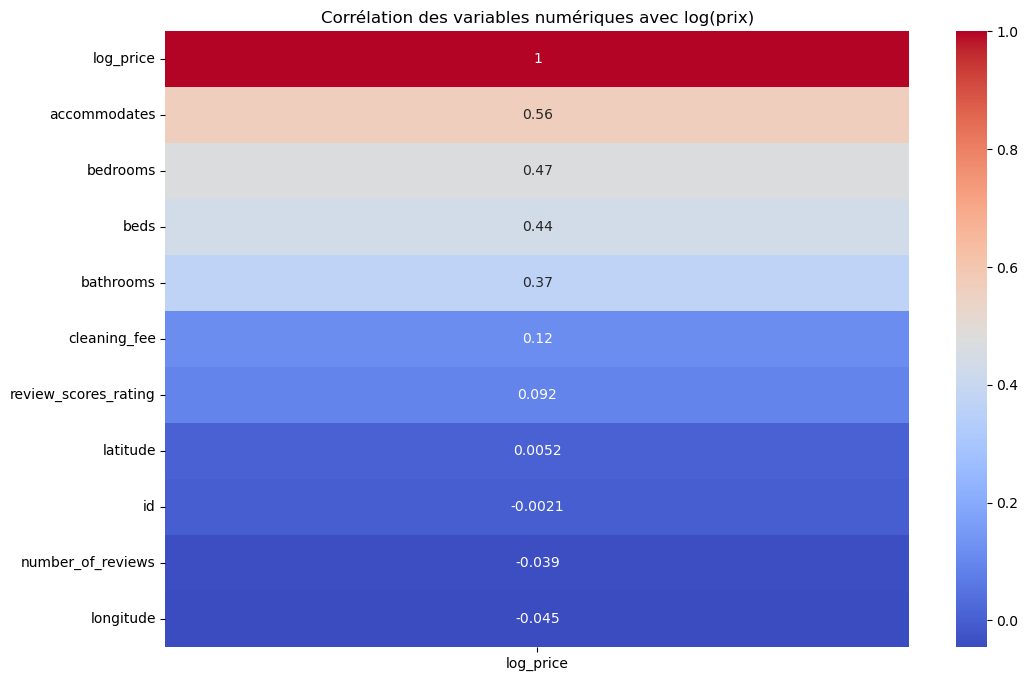

In [3]:


#  Prix selon le type de logement
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df, x='room_type', y='log_price')
plt.title("Prix (log) selon le type de chambre")
plt.xlabel("Type de chambre")
plt.ylabel("log(prix)")
plt.show()


#  Corrélations numériques
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['log_price']].sort_values(by='log_price', ascending=False), annot=True, cmap='coolwarm')
plt.title("Corrélation des variables numériques avec log(prix)")
plt.show()




I therefore carried out a correlation analysis
to identify the variables that have the greatest influence on price.
The strongest correlation is observed with the variable accommodates (correlation of 0.56),
which is completely logical:
the more people a listing can accommodate, the more its price tends to increase.

I also examined which amenities were the most important to consider—
that is, those for which there is a large price difference
between listings that include the amenity and those that do not.

In [4]:

#  Effet des équipements
amenities_cols = [col for col in train_df.columns if col.startswith("has_")]
if amenities_cols:
    melted = train_df[amenities_cols + ['log_price']].melt(id_vars='log_price')
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=melted, x='variable', y='log_price', hue='value')
    plt.title("Effet des équipements sur le log(prix)")
    plt.xticks(rotation=45)
    plt.legend(title='Présence')
    plt.tight_layout()
    plt.show()


Out of curiosity, I wanted to see where the listings were located,
so I plotted latitude and longitude on a graph.
We observe that the accommodations are mainly concentrated in a few regions,
particularly around the area (latitude = 34, longitude = –118),
which corresponds to California.

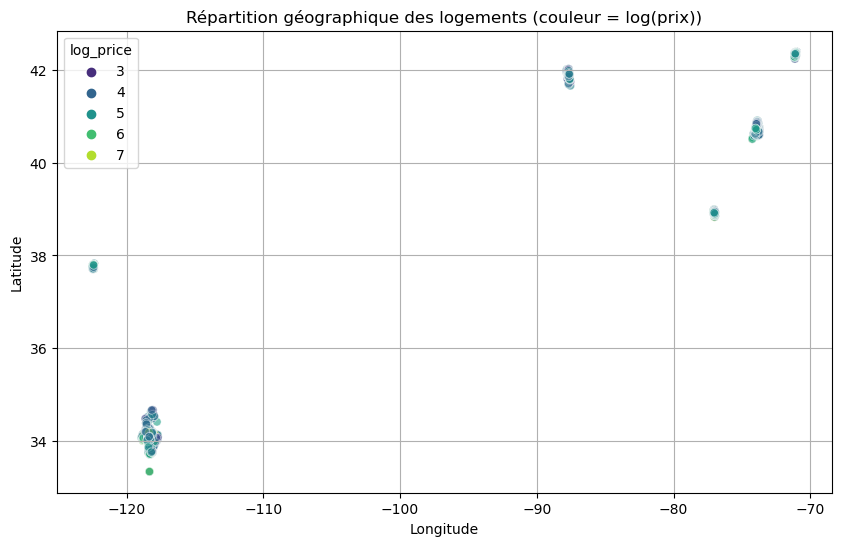


Ce que je pense important de retenir pour le modèle de prédiction du log-prix :
- Coordonnées (latitude, longitude) : conservées pour refléter l'impact de la localisation
- 'room_type' : conservée car elle a un effet significatif sur le prix
- 'name' : transformée en 'name_length' pour capter une information indirecte
- 'amenities' : transformée en colonnes binaires (has_wifi, has_pool, etc.)
- 'last_review' : transformée en mois et année pour exploiter la date du dernier avis


In [5]:

    #  Répartition géographique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='longitude', y='latitude', hue='log_price', palette='viridis', alpha=0.6)
plt.title("Répartition géographique des logements (couleur = log(prix))")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='log_price')
plt.grid(True)
plt.show()

# Choix des partis pris grâce aux résultats de l'analyse quantitative des données:
print("\nCe que je pense important de retenir pour le modèle de prédiction du log-prix :")
print("- Coordonnées (latitude, longitude) : conservées pour refléter l'impact de la localisation")
print("- 'room_type' : conservée car elle a un effet significatif sur le prix")
print("- 'name' : transformée en 'name_length' pour capter une information indirecte")
print("- 'amenities' : transformée en colonnes binaires (has_wifi, has_pool, etc.)")
print("- 'last_review' : transformée en mois et année pour exploiter la date du dernier avis")


In [6]:
""""
Partie prédiction de Log-prix 

""" 
#  2. Fonction de préparation des données
def prepare_data(df):
    df = df.copy()  # On travaille sur une copie des données originales

    # Équipements recherchés
    amenities_to_check = ['Wifi', 'Pool', 'Air Conditioning', 'Kitchen', 'Heating', 'TV', 'Washer', 'Dryer', 'Gym']
    for a in amenities_to_check:
        df[f'has_{a.lower().replace(" ", "_")}'] = df['amenities'].str.contains(a, case=False, na=False).astype(int)

    # Longueur du titre de l'annonce
    df['name_length'] = df['name'].str.len().fillna(0)

    # Est-ce que le logement a des avis ?
    df['has_reviews'] = df['number_of_reviews'] > 0

    # Conversion de la date du dernier avis
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df['last_review_year'] = df['last_review'].dt.year.fillna(0)
    df['last_review_month'] = df['last_review'].dt.month.fillna(0)

    # Regrouper les quartiers peu fréquents dans "Other"
    if 'neighbourhood' in df.columns:
        top_neigh = df['neighbourhood'].value_counts().nlargest(15).index
        df['neighbourhood'] = df['neighbourhood'].where(df['neighbourhood'].isin(top_neigh), 'Other')

    return df

print(" Préparation des données...")
train_df = prepare_data(train_df)

#  3. Séparer les variables (X) et la cible à prédire (y)
X = train_df.drop(columns=['log_price', 'id', 'name', 'amenities', 'last_review'], errors='ignore')
y = train_df['log_price']

#  Découpage en données d'entraînement (95%) et de validation (05%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)
print(f" Données d'entraînement : {X_train.shape[0]} lignes")
print(f" Données de validation : {X_val.shape[0]} lignes")

#  4. Préparation des transformations
num_features = X_train.select_dtypes(include=np.number).columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

#  Transformation logarithmique sur certaines colonnes
skewed_features = ['number_of_reviews']
for col in skewed_features:
    if col in num_features:
        X_train[col] = np.log1p(X_train[col])
        X_val[col] = np.log1p(X_val[col])

#  Pipeline de transformation
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_features)
])
train_df.sample(3)

 Préparation des données...
 Données d'entraînement : 21122 lignes
 Données de validation : 1112 lignes


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,has_kitchen,has_heating,has_tv,has_washer,has_dryer,has_gym,name_length,has_reviews,last_review_year,last_review_month
11157,20000184,4.248495,Apartment,Private room,"{TV,Internet,""Wireless Internet"",""Air conditio...",1,1.0,Real Bed,strict,True,...,1,1,1,0,1,0,44,True,2017.0,9.0
744,18716795,3.912023,Apartment,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",2,2.0,Real Bed,flexible,False,...,1,1,0,1,1,0,16,True,2016.0,1.0
14532,4729142,5.855072,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",3,1.0,Real Bed,strict,True,...,1,1,1,1,1,1,31,False,0.0,0.0


    3. Data Preprocessing
a. Feature Enrichment

The prepare_data() function adds relevant derived variables:
-Presence of specific amenities (Wifi, Pool, Air Conditioning, etc.),
-Length of the listing title (name_length),
-Presence or absence of reviews (has_reviews),
-Year and month of the last review, extracted after converting last_review,
-Simplification of neighborhoods: only the 15 most frequent ones are kept, and the others are grouped into an "Other" category.
This preprocessing step aims to provide the model with simple but meaningful indicators.

b. Handling Missing Values and Data Types

Numerical variables are imputed using the median and standardized with a StandardScaler,
while categorical variables are imputed with a constant and encoded using one-hot encoding (OHE).
This pipeline is integrated into a ColumnTransformer to simultaneously process the different types of columns.

c. Target and Feature Transformation

The model predicts log_price, i.e., the natural logarithm of the price,
in order to reduce variance and stabilize extreme values.
Additionally, some columns such as number_of_reviews, which are highly skewed,
are also transformed using a logarithmic scale.

 Entraînement du modèle...

 Résultats sur validation:
 RMSE: 0.3962
 R²: 0.6851


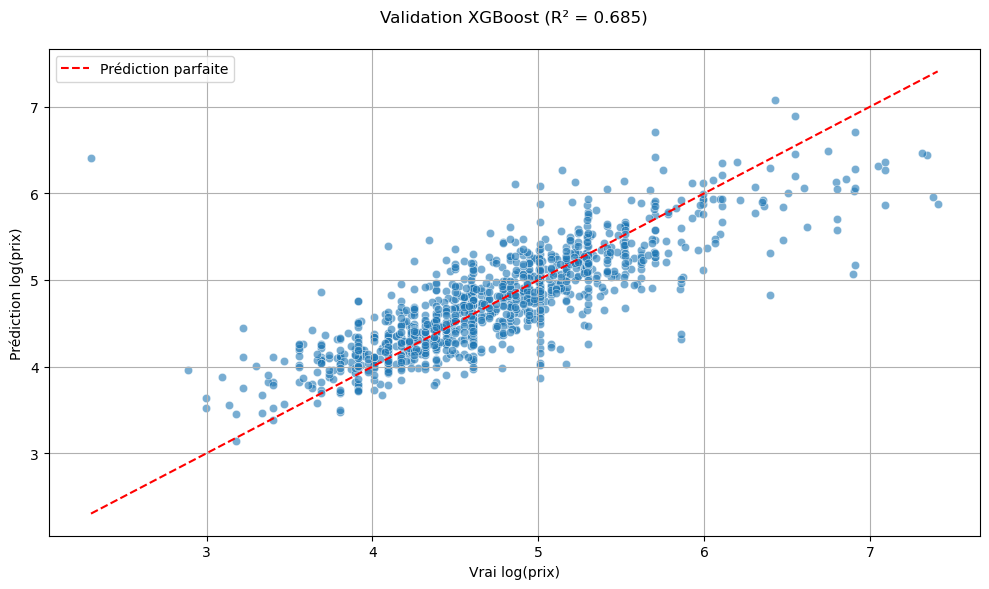

In [7]:
#  5. Création du modèle XGBoost
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

#  6. Entraînement du modèle
print(" Entraînement du modèle...")
model.fit(X_train, y_train)

#  7. Prédiction sur les données de validation
y_pred = model.predict(X_val)

#  8. Évaluation des performances
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("\n Résultats sur validation:")
print(f" RMSE: {rmse:.4f}")
print(f" R²: {r2:.4f}")



#  9. Sauvegarde des prédictions de validation
results_val = pd.DataFrame({
    'id': train_df.loc[X_val.index, 'id'],
    'log_price_reel': y_val,
    'log_price_pred': y_pred,
    'difference': np.abs(y_val - y_pred)
})
results_val.to_csv('validation_predictions_xgb.csv', index=False)

#  10. Visualisation des résultats
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_price_reel', y='log_price_pred', data=results_val, alpha=0.6)
plt.plot([results_val['log_price_reel'].min(), results_val['log_price_reel'].max()],
         [results_val['log_price_reel'].min(), results_val['log_price_reel'].max()],
         'r--', label='Prédiction parfaite')
plt.title(f"Validation XGBoost (R² = {r2:.3f})", pad=20)
plt.xlabel('Vrai log(prix)')
plt.ylabel('Prédiction log(prix)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('validation_plot_xgb.png')
plt.show()


    4.Model Training

a. Train–Validation Split

The training dataset is divided into:
-95% for training,
-5% for validation,
in order to evaluate the model’s ability to generalize.

b. XGBoost Model

The XGBoost model is configured with:
-500 trees,
-maximum depth of 7,
-learning rate of 0.1,
-80% subsampling (both row and column subsampling) to reduce overfitting.

The model is wrapped inside a Pipeline along with the preprocessor, ensuring a clean integration of all preprocessing and learning steps.

    5.Performance Evaluation

Predictions are evaluated on the validation set using two metrics:

RMSE (Root Mean Squared Error) and R² (coefficient of determination)

The results obtained are:

RMSE: ~0.39

R²: ~0.69, which is significantly better than my first models, which barely exceeded 0.45.

These results surpass the initial target (R² ≈ 0.63), showing that the model is capable of capturing most of the variance in log-price from the available features.
Nevertheless, it would certainly be possible to achieve even better performance with more training data and by further refining the preprocessing steps and model tuning.

My visualization of the results shows a good alignment around the ideal perfect-prediction line in red.

In [8]:

#  11. PRÉDICTION SUR LES DONNÉES DE TEST
print("\n Prédiction sur les données de test...")

# Préparation des données de test
test_df_prepared = prepare_data(test_df)

# On s'assure d'avoir les mêmes colonnes que pour l'entraînement
test_df_prepared = test_df_prepared[X_train.columns]

# Prédiction
test_predictions = model.predict(test_df_prepared)

# Création du fichier de résultats
results_test = pd.DataFrame({
    'id': test_df['Unnamed: 0'],  # Utilisation de la colonne d'index comme id
    'log_price': test_predictions
})

# Sauvegarde
results_test.to_csv('test_predictions.csv', index=False)
print(" Prédictions sur test sauvegardées dans 'test_predictions.csv'")
print(f" Nombre de prédictions : {len(results_test)}")
print("\nAperçu des prédictions :")
print(results_test.head())

print("\n Tâches terminées avec succès !")


 Prédiction sur les données de test...
 Prédictions sur test sauvegardées dans 'test_predictions.csv'
 Nombre de prédictions : 51877

Aperçu des prédictions :
         id  log_price
0  14282777   4.842090
1  17029381   5.888589
2   7824740   4.885946
3  19811650   5.946587
4  12410741   4.521002

 Tâches terminées avec succès !


5. Prédiction finale et export

Le jeu de test est traité avec le même pipeline que les données d'entraînement. Une attention particulière est portée à l'alignement des colonnes avec celles de l’entraînement pour éviter des erreurs lors de la prédiction. Les prédictions sont ensuite exportées dans un fichier test_predictions.csv.

6. Conclusion

j'ai pu apprendre pas mal de choses, que ce soit sur la préparation des données, les visualisations, ou l’entraînement d’un modèle comme XGBoost. Et ça a été interessant de voir que même avec quelques ajustements simples, on pouvait améliorer les résultats.

Des pistes d’amélioration futures pourraient inclure :

l’exploration de modèles alternatifs (LightGBM, CatBoost),

la création de nouvelles variables temporelles (saisonnalité, durée depuis la dernière réservation),

un tuning plus approfondi des hyperparamètres via une recherche bayésienne ou un GridSearchCV.

Paul BULLIER
